In [1]:
import kessler
from kessler import EventDataset
import pandas as pd
import numpy as np
from kessler.nn import LSTMPredictor
from kessler.data import kelvins_to_event_dataset




In [4]:
filename = "/Users/soumilrathi/Desktop/Python/Research/train_data.csv"
events = kelvins_to_event_dataset(filename, drop_features = ['c_rcs_estimate', 't_rcs_estimate'], num_events=1000)
data = pd.read_csv(filename)

Loading Kelvins dataset from file name: /Users/soumilrathi/Desktop/Python/Research/train_data.csv
162634 entries
Dropping features: ['c_rcs_estimate', 't_rcs_estimate']
Dropping rows with NaNs
146571 entries
Removing outliers
127037 entries
Shuffling
Grouped rows into 9586 events
Taking TCA as current time: 2021-07-04 20:32:13.130832
Converting Kelvins challenge data to EventDataset
Time spent  | Time remain.| Progress             | Events    | Events/sec
0d:00:00:16 | 0d:00:00:00 | #################### | 1000/1000 | 60.26       


In [23]:
kessler_stats = events.to_dataframe().describe()
print(kessler_stats)


Converting EventDataset to DataFrame
Time spent  | Time remain.| Progress             | Events    | Events/sec
0d:00:01:56 | 0d:00:00:00 | #################### | 1000/1000 | 8.60        
       MISS_DISTANCE  RELATIVE_SPEED  RELATIVE_POSITION_R  \
count   13611.000000    13611.000000         13611.000000   
mean    14896.142826    10712.031004           -18.707105   
std     13801.036333     4042.088258           577.559322   
min        40.000000      149.000000         -4470.500000   
25%      4016.000000     7877.000000          -235.800000   
50%     10014.000000    11913.000000           -18.000000   
75%     22604.000000    14302.000000           212.350000   
max     64250.000000    16433.000000          1998.900000   

       RELATIVE_POSITION_T  RELATIVE_POSITION_N  RELATIVE_VELOCITY_R  \
count         13611.000000         13611.000000         13611.000000   
mean            304.262751           410.745867            -1.276850   
std           13824.042163         14855.829051

In [24]:
events

EventDataset(Events:1000, number of CDMs per event: 1 (min), 22 (max), 13.61 (mean))

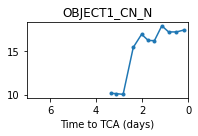

In [28]:
events[10].plot_features('OBJECT1_CN_N')

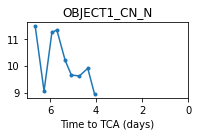

In [29]:
events[505].plot_features('OBJECT1_CN_N')

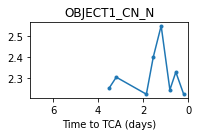

In [30]:
events[960].plot_features('OBJECT1_CN_N')

In [22]:
events_test[10]

Event(CDMs: 8)

In [13]:

# Create an LSTM predictor, specialized to the nn_features we extracted above
model = LSTMPredictor(
            lstm_size=256,  # Number of hidden units per LSTM layer
            lstm_depth=2,  # Number of stacked LSTM layers
            dropout=0.2,  # Dropout probability
            features=nn_features)  # The list of feature names to use in the LSTM

In [40]:
model.learn(events_train_and_val, 
            epochs=50, # Number of epochs (one epoch is one full pass through the training dataset)
            lr=1e-4, # Learning rate, can decrease it if training diverges
            batch_size=16, # Minibatch size, can be decreased if there are issues with memory use
            device='cpu', # Can be 'cuda' if there is a GPU available
            valid_proportion=0.30, # Proportion of the data to use as a validation set internally
            num_workers=4, # Number of multithreaded dataloader workers, 4 is good for performance, but if there are any issues or errors, please try num_workers=1 as this solves issues with PyTorch most of the time
            event_samples_for_stats=6000) # Number of events to use to compute NN normalization factors, have this number as big as possible (and at least a few thousands)

LSTM predictor with params: 875,074


Saving LSTM predictor to file: LSTM_20epochs_lr10-4_batchsize16
Plotting to file: plot_loss.pdf


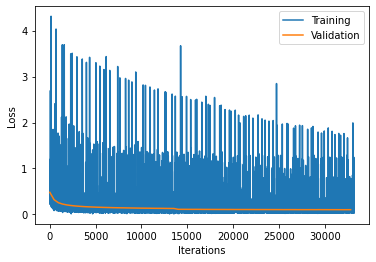

In [41]:
model.save(file_name="LSTM_20epochs_lr10-4_batchsize16")
model.plot_loss(file_name='plot_loss.pdf')

In [42]:
events_train_and_val[0][0]

CCSDS_CDM_VERS                        = 1.0
CREATION_DATE                         = 2021-06-20T03:36:06.878280
ORIGINATOR                            =
MESSAGE_ID                            =
TCA                                   = 2021-06-21T17:12:18.245280
MISS_DISTANCE                         = 14923.0
RELATIVE_SPEED                        = 13792.0
RELATIVE_POSITION_R                   = 453.8
RELATIVE_POSITION_T                   = 5976.6
RELATIVE_POSITION_N                   = -13666.8
RELATIVE_VELOCITY_R                   = -7.2
RELATIVE_VELOCITY_T                   = -12637.0
RELATIVE_VELOCITY_N                   = -5525.9
OBJECT                                = OBJECT1
OBJECT_DESIGNATOR                     =
CATALOG_NAME                          =
OBJECT_NAME                           =
INTERNATIONAL_DESIGNATOR              =
EPHEMERIS_NAME                        =
COVARIANCE_METHOD                     =
MANEUVERABLE                          =
REF_FRAME                         

In [43]:

#we take a single event, we remove the last CDM and try to predict it
event=events_test[10]
event_len = len(event)
print(event)
event_beginning = event[0:event_len-1]
print(event_beginning)
event_evolution = model.predict_event_step(event_beginning, num_samples = 100)

Event(CDMs: 20)
Event(CDMs: 19)


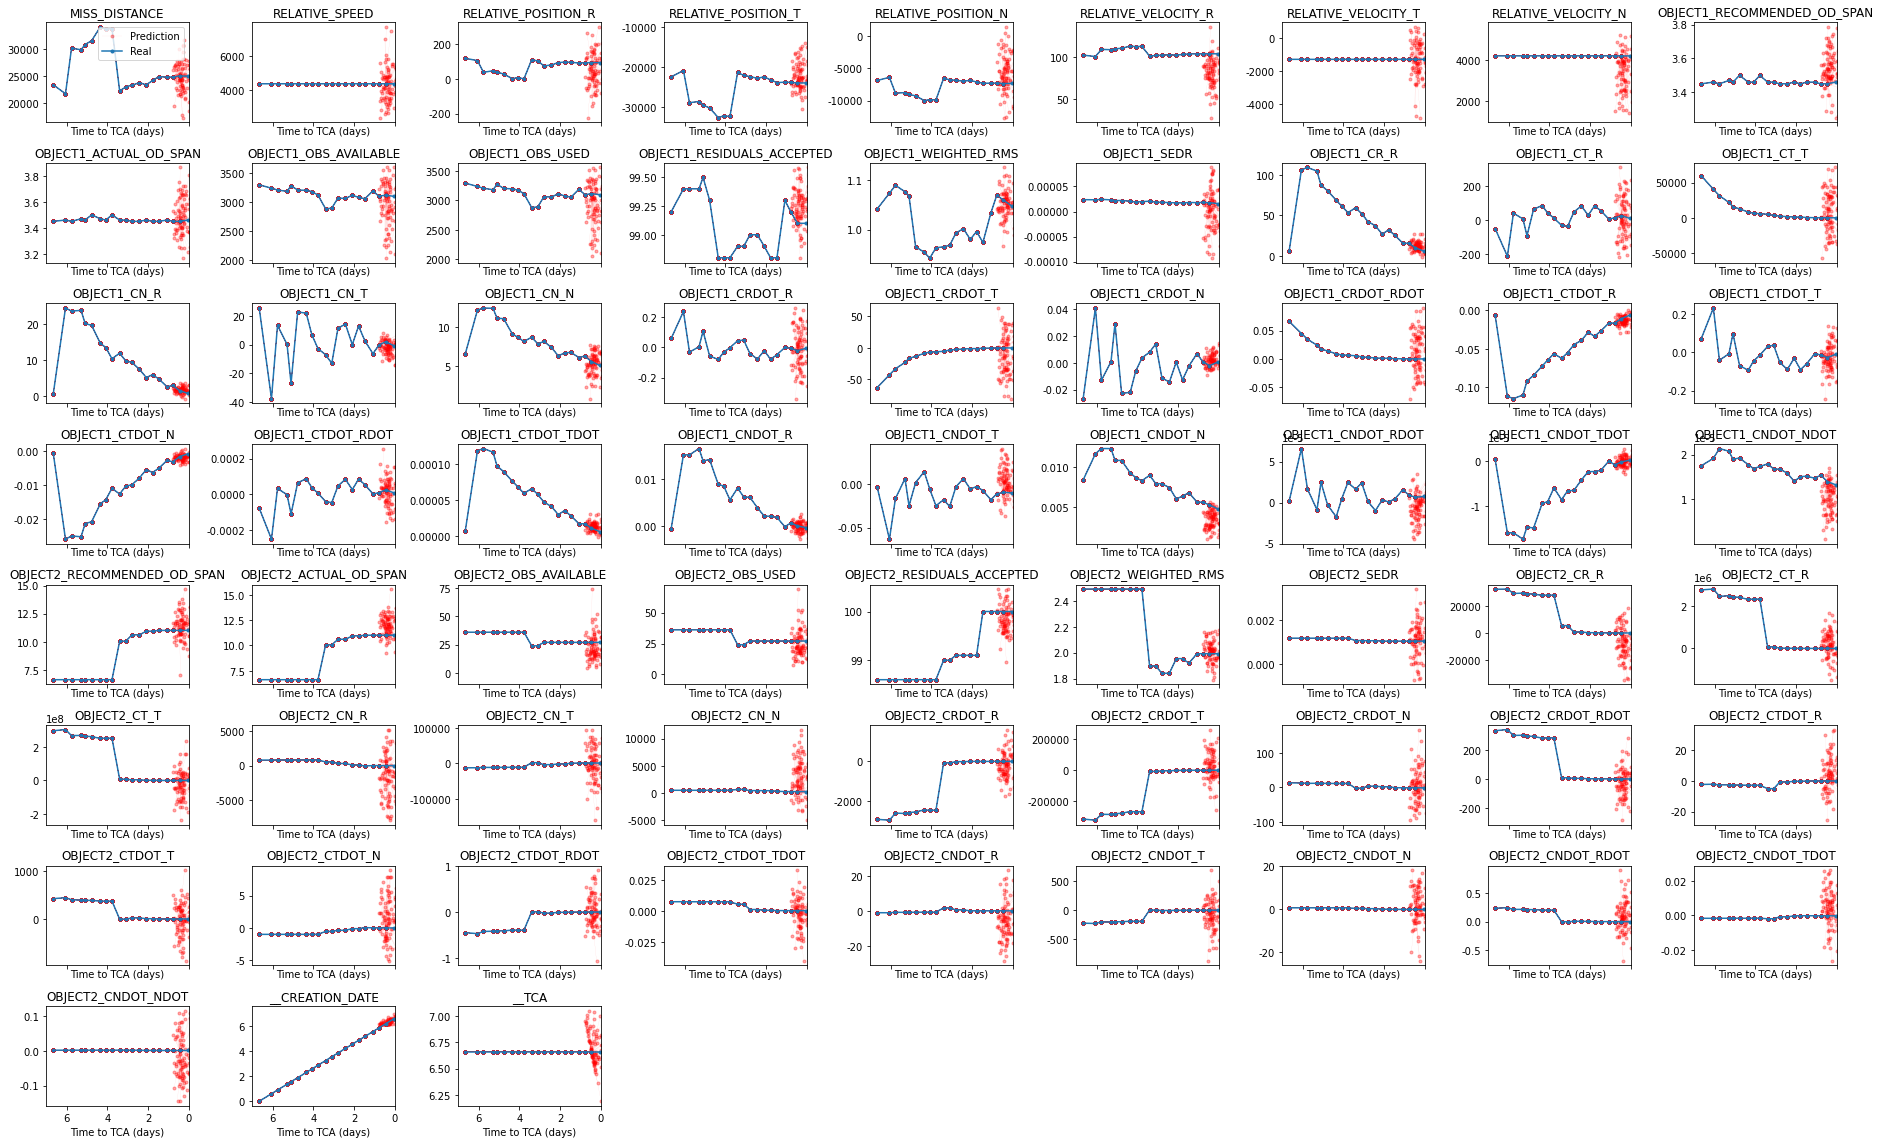

In [49]:
import matplotlib.pyplot as plt
#We plot the prediction in red:
axs = event_evolution.plot_features(nn_features, return_axs=True, linewidth=0.1, color='red', alpha=0.33, label='Prediction')
#and the ground truth value in blue:
event.plot_features(nn_features, axs=axs, label='Real', legend=True)
plt.savefig('CDMPred.png')

EventDataset(Events:100, number of CDMs per event: 20 (min), 20 (max), 20.00 (mean))

LSTMPredictor(
  (lstm): LSTM(66, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=256, out_features=66, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
)